### Wasserstein GAN
 - Use EM distance; known as Wasserstein loss
 - We do not need Sigmoid layer at the end ==> The result can be -inf to inf
 - After every updating, cliping the parameters of critic(discriminator)
 - Updating critic n times before updating generator

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import RandomSampler

import torchvision
import torchvision.transforms as tfms
import torchvision.datasets as dsets

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

# Windows의 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')

"""
# Mac의 한글 폰트 설정
plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=Flase)
"""
# 선명한 폰트
set_matplotlib_formats('retina')

In [3]:
channels = 1; img_size = 28
img_shape = (channels, img_size, img_size)

class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        
        def Basic_block(in_feature, out_feature, normalize=True):
            layers = [nn.Linear(in_feature, out_feature)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feature, momentum=0.8))
            layers.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))
            return layers
        
        self.latent_dim = latent_dim
        self.generator = nn.Sequential(
            *Basic_block(self.latent_dim, 128, normalize=False),
            *Basic_block(128, 256),
            *Basic_block(256, 512),
            *Basic_block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )
        
        self.reshape = ()
        
    def forward(self, z):
        img = self.generator(z)
        img = img.view(img.shape[0], *img_shape)
        return img

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.discriminator = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.discriminator(img_flat)
        return validity

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device == torch.device("cuda"):
    torch.cuda.benchmark = True

latent_dim = 100
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

In [6]:
from torchsummaryM import summary

summary(generator, (16, 100), device=device)
summary(discriminator, (16, 1, 28, 28), device=device)

------------------------------------------------------------------------------------------------
Layer(type)                         ||        Kernel Shape         Output Shape         Param #
Generator Inputs                    ||                   -            [16, 100]               -
                                    ||                                                         
01> Generator-Generator-Linear      ||          [100, 128]            [16, 128]          12,928
02> Generator-Generator-LeakyReLU   ||                   -            [16, 128]               0
03> Generator-Generator-Linear      ||          [128, 256]            [16, 256]          33,024
04> Generator-Generator-BatchNorm1d ||               [256]            [16, 256]             512
05> Generator-Generator-LeakyReLU   ||                   -            [16, 256]               0
06> Generator-Generator-Linear      ||          [256, 512]            [16, 512]         131,584
07> Generator-Generator-BatchNorm1d || 

(OrderedDict([('1> Discriminator-Discriminator-Linear',
               OrderedDict([('id', 2549135134856),
                            ('output_size', 1),
                            ('output_shape', [16, 512]),
                            ('ksize', [784, 512]),
                            ('nb_params', 401920),
                            ('trainable', True)])),
              ('2> Discriminator-Discriminator-LeakyReLU',
               OrderedDict([('id', 2549135262984),
                            ('output_size', 1),
                            ('output_shape', [16, 512]),
                            ('ksize', '-'),
                            ('nb_params', 0)])),
              ('3> Discriminator-Discriminator-Linear',
               OrderedDict([('id', 2549135262216),
                            ('output_size', 1),
                            ('output_shape', [16, 256]),
                            ('ksize', [512, 256]),
                            ('nb_params', 131328),
            

In [7]:
transforms = tfms.Compose([
    tfms.ToTensor(),
    tfms.Normalize([0.5,], [0.5, ])
])


train_dataset = dsets.MNIST(
    root='./data/',
    train=True,
    download = True,
    transform=transforms
)

test_dataset = dsets.MNIST(
    root='./data/',
    train=False,
    download = True,
    transform=transforms
)

dataset = train_dataset

In [8]:
data_loader = DataLoader(
    dataset = dataset,
    batch_size = 256,
    shuffle=True
)

In [9]:
# optimizers
# optimizer_G = optim.Adam(generator.parameters(), lr=0.00005)
# optimizer_D = optim.Adam(discriminator.parameters(), lr=0.00005)
optimizer_G = optim.RMSprop(generator.parameters(), lr=0.00005)
optimizer_D = optim.RMSprop(discriminator.parameters(), lr=0.00005)

In [11]:
from IPython.display import clear_output
data_size = len(data_loader)
def train(gen, dis, g_opt, d_opt, data_loader, epoch, epochs):
    for batch_idx, (img, label) in enumerate(data_loader):
        real_img = img.to(device)
        
        # ---------------------
        #  Train Discriminator
        # ---------------------
        for n_critic in range(5):
            d_opt.zero_grad()
            
            z = torch.randn((real_img.shape[0], latent_dim), dtype=torch.float).to(device)
            fake_img    = gen(z).detach()
            loss_D_real = -torch.mean(dis(real_img))
            loss_D_fake = torch.mean(dis(fake_img))
            loss_D = loss_D_real + loss_D_fake
            
            loss_D.backward()
            d_opt.step()
            
            for param in dis.parameters():
                param.data.clamp_(-0.01, 0.01)
        
            # ---------------------
            #  Train Generator
            # ---------------------
            if n_critic == 4:
#                 clear_output(wait=True)
                g_opt.zero_grad()
                
                fake_img = gen(z)
                loss_G   = -torch.mean(dis(fake_img))

                loss_G.backward()
                g_opt.step()
               
                if batch_idx % 1000 == 0:
                    template = "Epoch [{:2d}|{:2d}]    Step [{:5.2f}%  {:4d}|{:4d}]    D_Loss(Real||Fake) [{:8.6f} || {:8.6f}]    G_Loss {:8.6f}"
                    print(template.format(
                        epoch, epochs, 
                        ((batch_idx)/data_size)*100, batch_idx, data_size, 
                        loss_D_real.item(), loss_D_fake.item(),
                        loss_G.item()
                    ))
                    
                    img = fake_img.data[:25].detach().cpu()
                    torchvision.utils.save_image(img, "./images/Epoch_{:2d}_Step_[{:4d} {:4d}].png".format(epoch, batch_idx, data_size), nrow=5, normalize=True)

In [12]:
def test(model, fixed_sample, epoch):
    """
    visualise random results
    """
    model.eval()
    gen_img = model(fixed_sample)

    gen_imgs = torchvision.utils.make_grid(gen_img.detach(), nrow=4, normalize=True)
    
    plt.figure(figsize=(7, 7))
    plt.title("Epoch [{:2d}]    Generated Img".format(epoch))
    plt.axis("off")
    
    gen_imgs = gen_imgs.detach().cpu().numpy().transpose((1, 2, 0))
    plt.imshow(gen_imgs)
    plt.show()
    plt.close()

Epoch [ 1|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.087549 || 0.008211]    G_Loss -0.007370
Epoch [ 2|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-10.850728 || 10.803538]    G_Loss -10.829243
Epoch [ 3|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-7.925733 || 7.889645]    G_Loss -7.902686
Epoch [ 4|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-6.210818 || 6.190106]    G_Loss -6.172155
Epoch [ 5|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-5.296936 || 5.242200]    G_Loss -5.247389


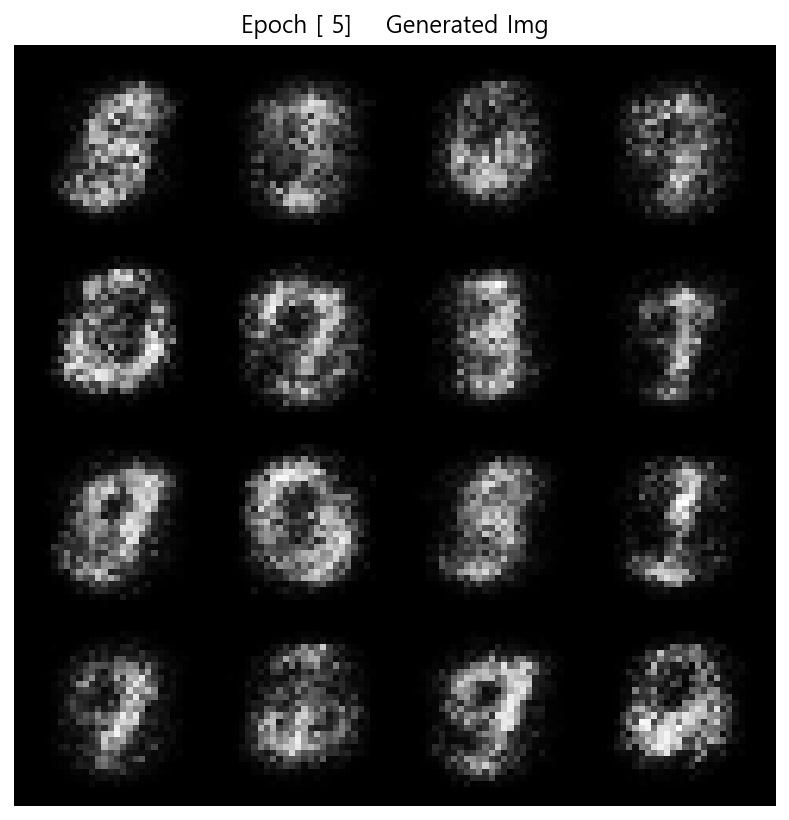

Epoch [ 6|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-5.573025 || 5.537301]    G_Loss -5.528397
Epoch [ 7|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-4.234712 || 4.208830]    G_Loss -4.208785
Epoch [ 8|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-3.950201 || 3.912616]    G_Loss -3.914291
Epoch [ 9|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-3.421129 || 3.371586]    G_Loss -3.409606
Epoch [10|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-2.784254 || 2.732862]    G_Loss -2.723687


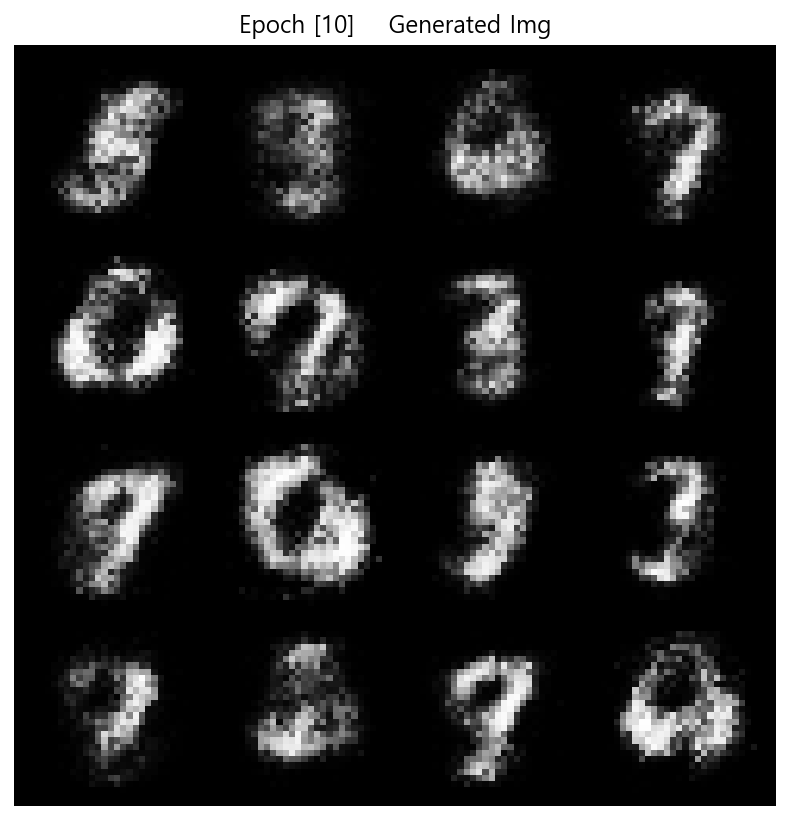

Epoch [11|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.981410 || 1.928873]    G_Loss -1.908704
Epoch [12|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.370367 || 1.289335]    G_Loss -1.275749
Epoch [13|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.377652 || 0.326525]    G_Loss -0.331989
Epoch [14|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.041693 || -0.133107]    G_Loss 0.128776
Epoch [15|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.058189 || -0.157291]    G_Loss 0.143691


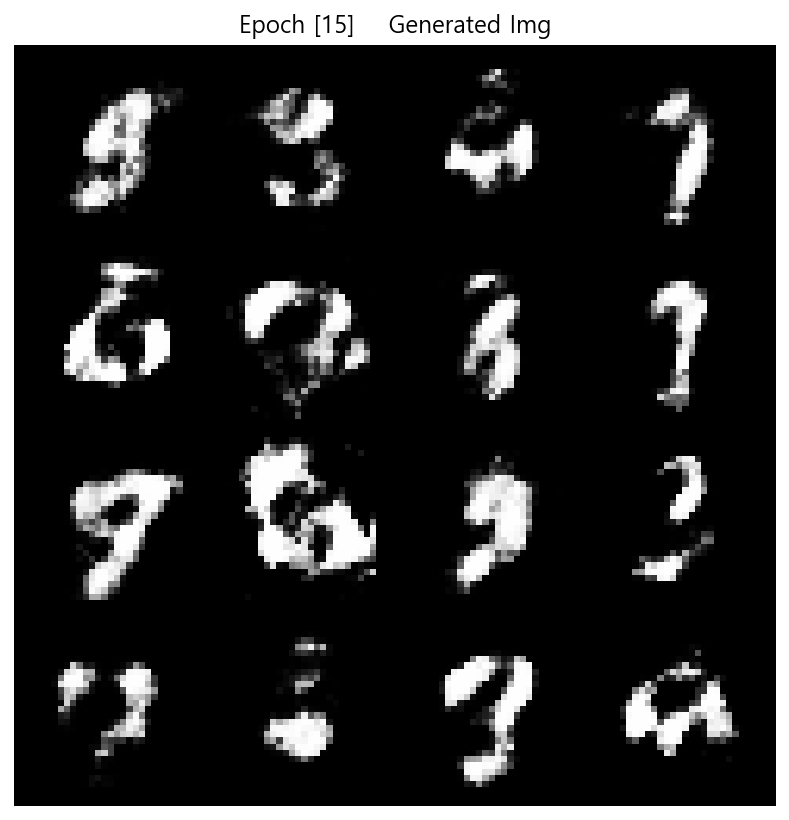

Epoch [16|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.008518 || -0.116099]    G_Loss 0.129793
Epoch [17|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.152543 || 0.044232]    G_Loss -0.044922
Epoch [18|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.035418 || -0.081474]    G_Loss 0.075164
Epoch [19|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.091904 || -0.017419]    G_Loss 0.027231
Epoch [20|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.035817 || -0.069691]    G_Loss 0.083953


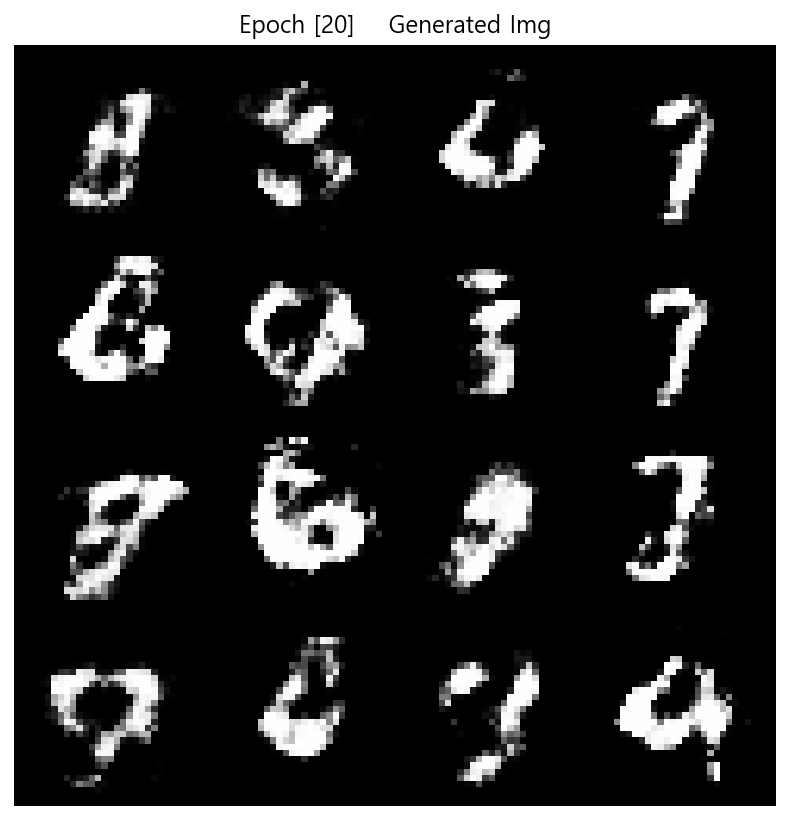

Epoch [21|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.142175 || 0.033294]    G_Loss -0.044673
Epoch [22|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.014507 || -0.115497]    G_Loss 0.101806
Epoch [23|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.035528 || -0.069554]    G_Loss 0.093313
Epoch [24|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.071497 || -0.172004]    G_Loss 0.173296
Epoch [25|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.024221 || -0.082309]    G_Loss 0.089558


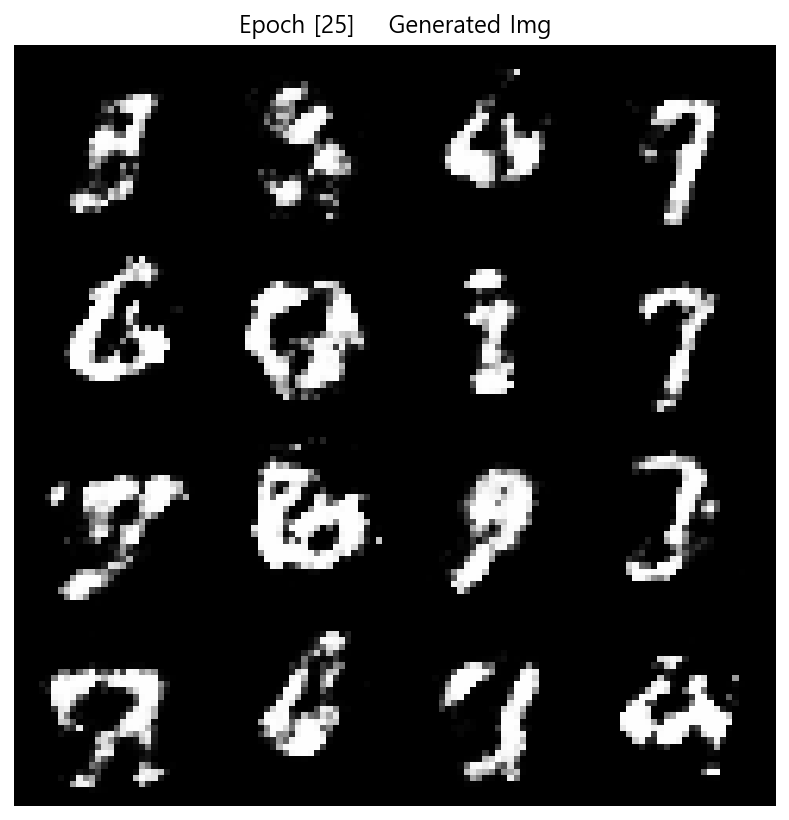

Epoch [26|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.242639 || 0.148033]    G_Loss -0.131828
Epoch [27|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.230152 || 0.137385]    G_Loss -0.138031
Epoch [28|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.125695 || 0.038002]    G_Loss -0.027690
Epoch [29|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.069046 || -0.032348]    G_Loss 0.061166
Epoch [30|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.093332 || 0.015326]    G_Loss 0.006488


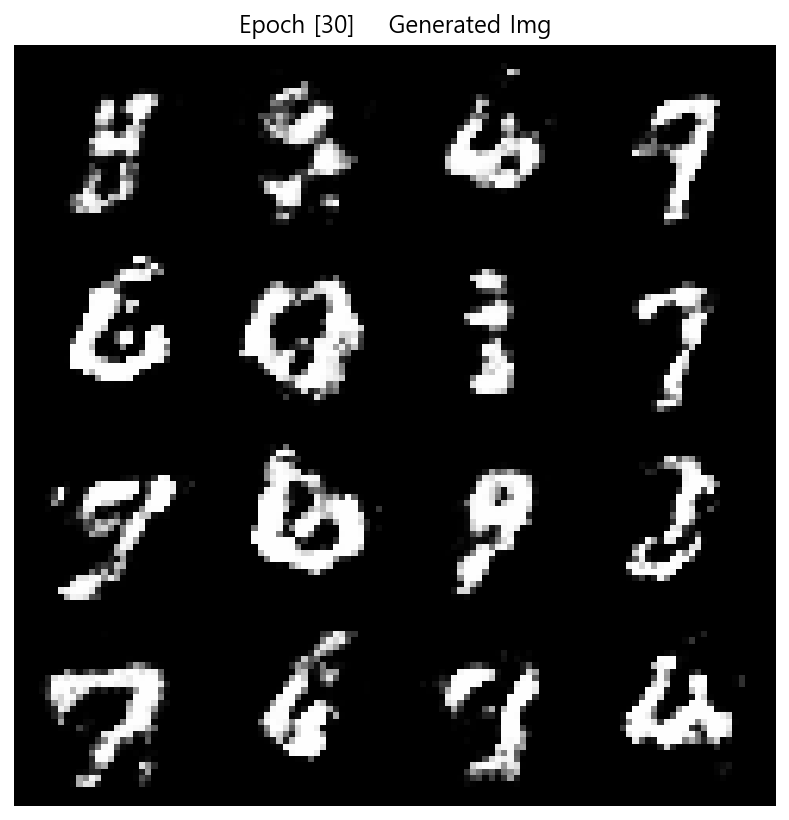

Epoch [31|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.198790 || 0.121124]    G_Loss -0.111743
Epoch [32|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.083032 || -0.005688]    G_Loss 0.040293
Epoch [33|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.058192 || -0.016790]    G_Loss 0.037892
Epoch [34|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.100323 || 0.029462]    G_Loss -0.029131
Epoch [35|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.246711 || 0.171086]    G_Loss -0.180275


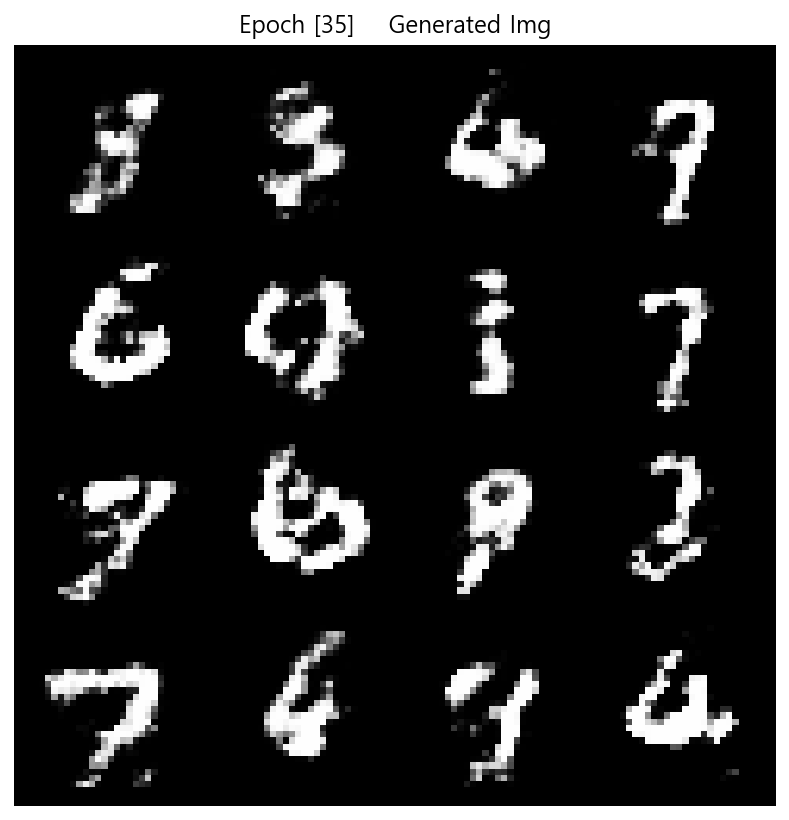

Epoch [36|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.115980 || -0.200733]    G_Loss 0.229341
Epoch [37|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.017182 || -0.057898]    G_Loss 0.044626
Epoch [38|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.190996 || 0.119003]    G_Loss -0.088556
Epoch [39|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.134694 || 0.060028]    G_Loss -0.046582
Epoch [40|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.167089 || 0.109289]    G_Loss -0.069837


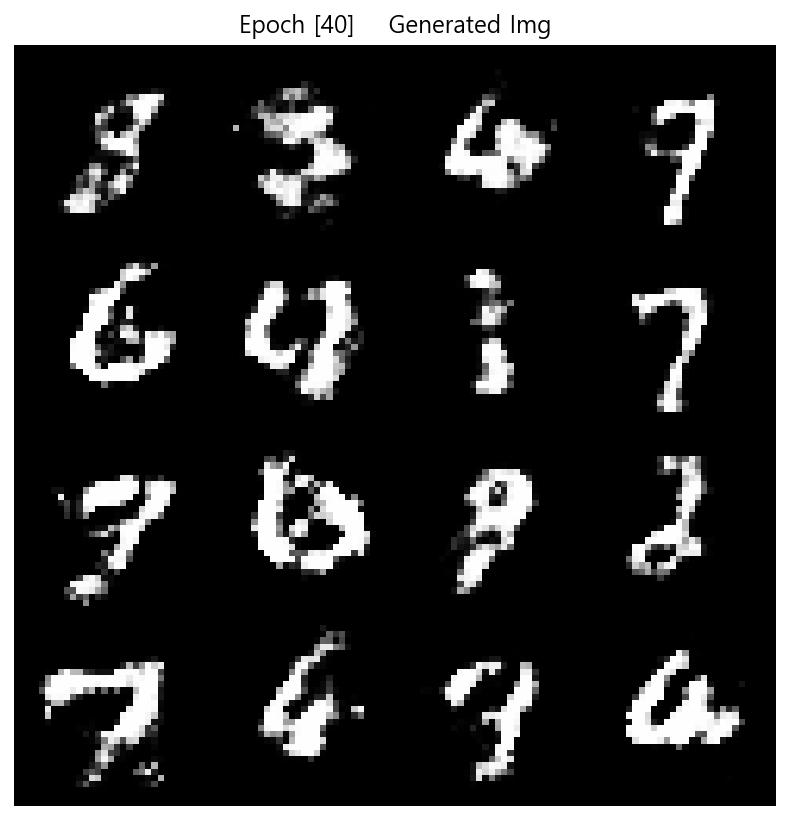

Epoch [41|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.173434 || 0.105216]    G_Loss -0.074098
Epoch [42|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.224503 || 0.146096]    G_Loss -0.146710
Epoch [43|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.297226 || 0.204782]    G_Loss -0.204873
Epoch [44|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.110382 || 0.045552]    G_Loss -0.040959
Epoch [45|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.082138 || 0.013318]    G_Loss -0.029181


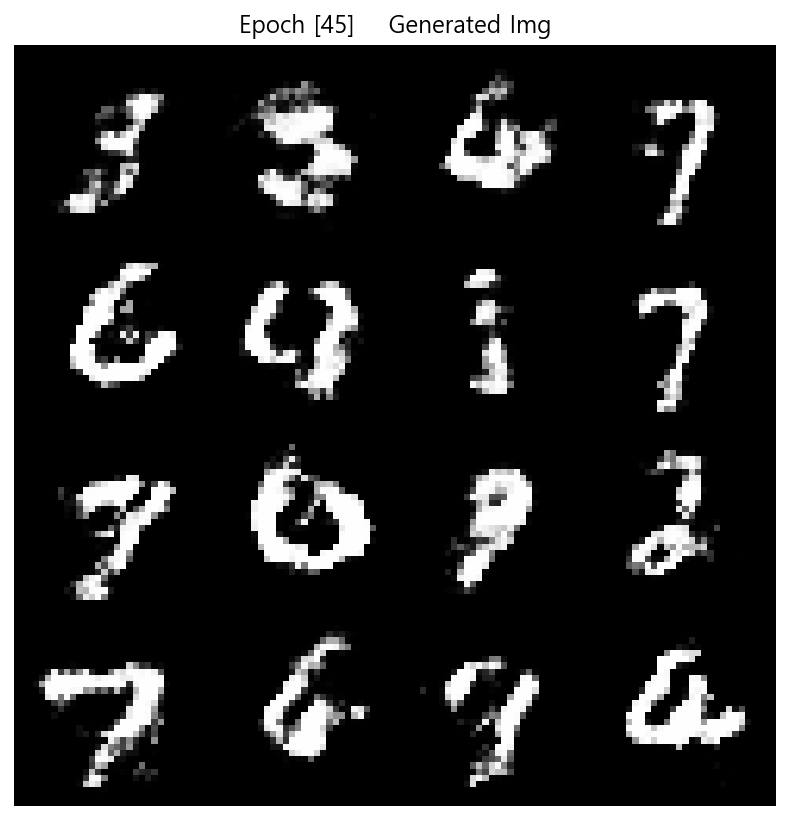

Epoch [46|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.122218 || 0.069981]    G_Loss -0.075007
Epoch [47|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.033206 || -0.004419]    G_Loss -0.008128
Epoch [48|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.029832 || -0.031535]    G_Loss 0.048188
Epoch [49|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.151596 || 0.093337]    G_Loss -0.079672
Epoch [50|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.141417 || 0.089974]    G_Loss -0.067980


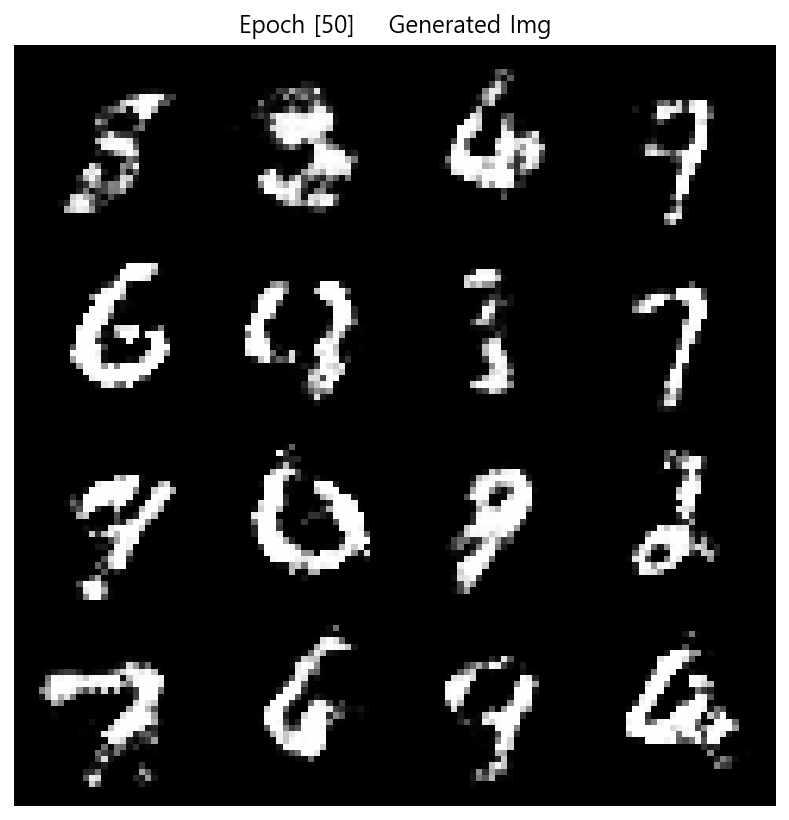

Epoch [51|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.124783 || 0.088642]    G_Loss -0.056865
Epoch [52|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.089891 || 0.041565]    G_Loss -0.002068
Epoch [53|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.040731 || -0.015096]    G_Loss 0.014541
Epoch [54|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.027638 || -0.039100]    G_Loss 0.052499
Epoch [55|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.044374 || -0.009096]    G_Loss 0.043319


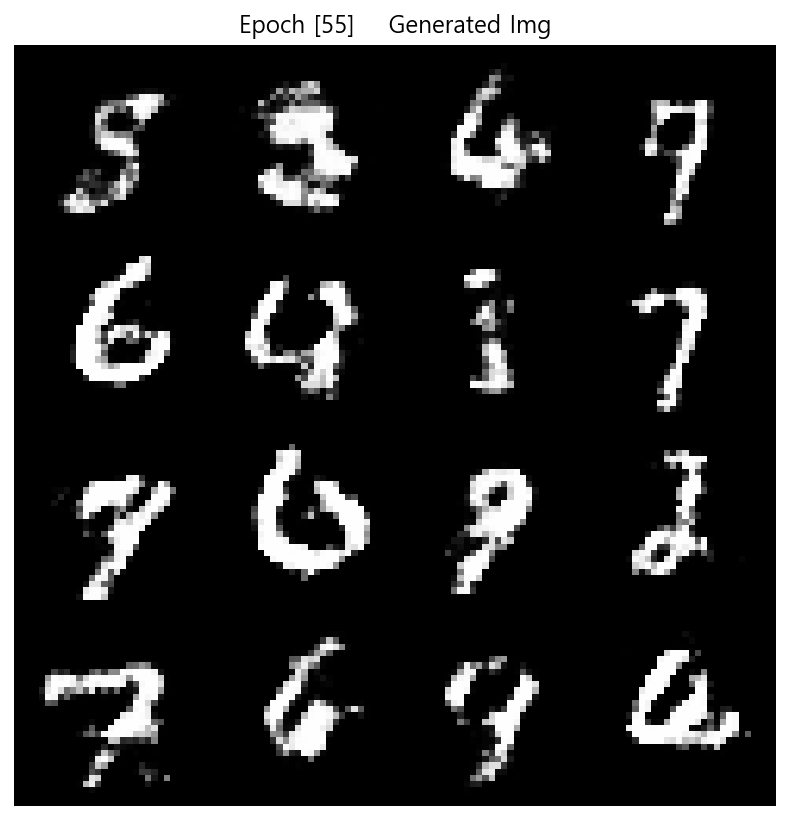

Epoch [56|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.019051 || -0.035480]    G_Loss 0.045349
Epoch [57|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.002839 || -0.036847]    G_Loss 0.040998
Epoch [58|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.158000 || 0.104007]    G_Loss -0.115842
Epoch [59|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.101867 || 0.052089]    G_Loss -0.029339
Epoch [60|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.112698 || 0.065113]    G_Loss -0.036822


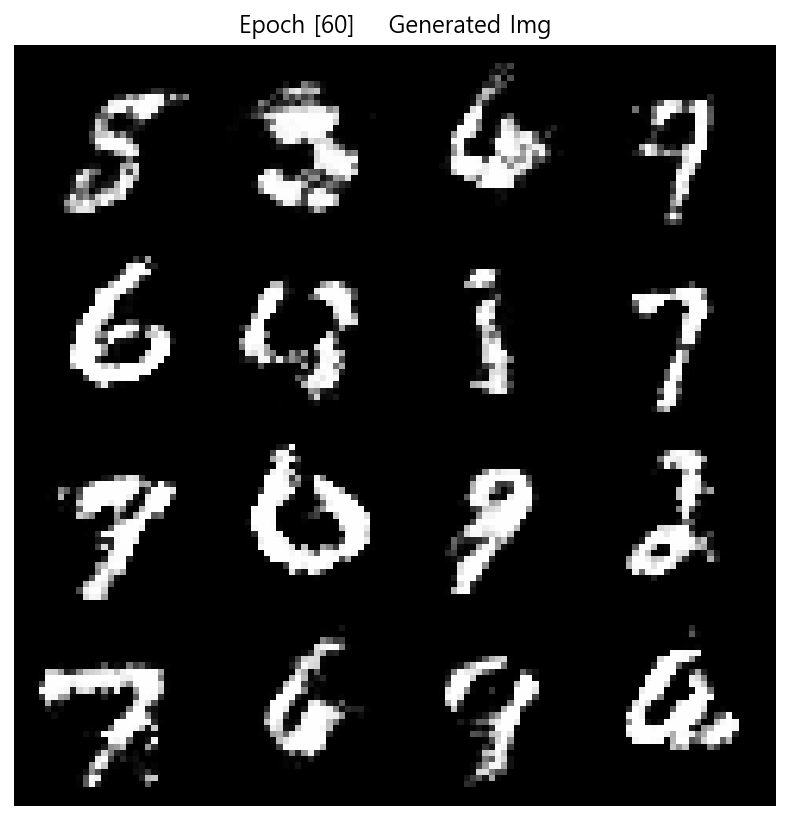

Epoch [61|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.199486 || 0.137172]    G_Loss -0.141635
Epoch [62|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.068178 || 0.035537]    G_Loss -0.009349
Epoch [63|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.157185 || 0.134710]    G_Loss -0.124009
Epoch [64|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.083526 || -0.126877]    G_Loss 0.136496
Epoch [65|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.030866 || -0.014639]    G_Loss 0.026992


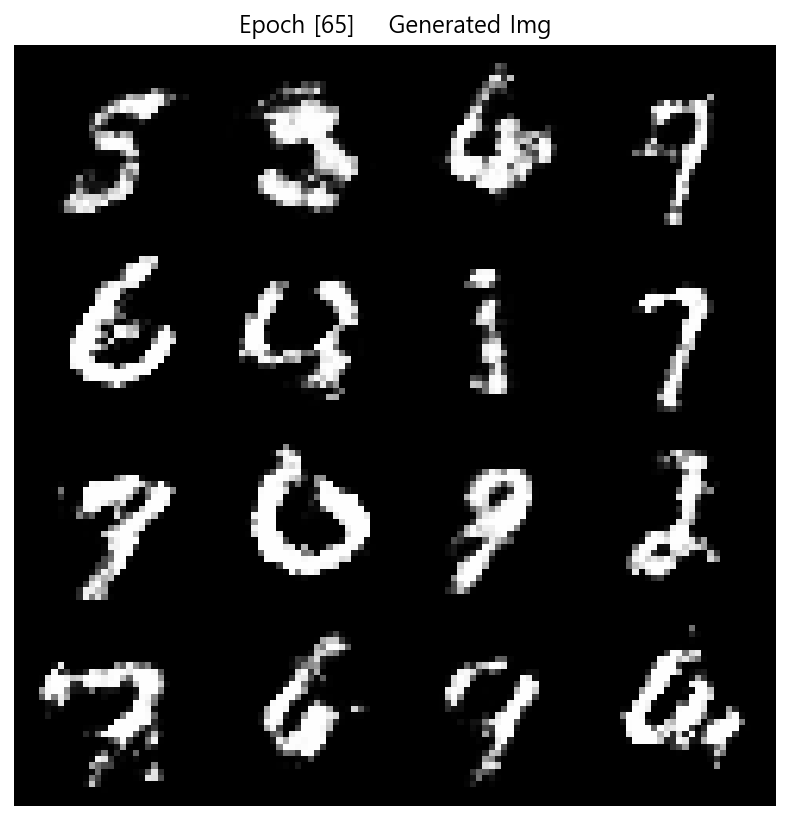

Epoch [66|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.054753 || -0.002241]    G_Loss 0.011620
Epoch [67|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.021130 || -0.005043]    G_Loss 0.002235
Epoch [68|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.009797 || -0.055624]    G_Loss 0.068032
Epoch [69|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.077467 || 0.051655]    G_Loss -0.041455
Epoch [70|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.166592 || -0.205426]    G_Loss 0.209490


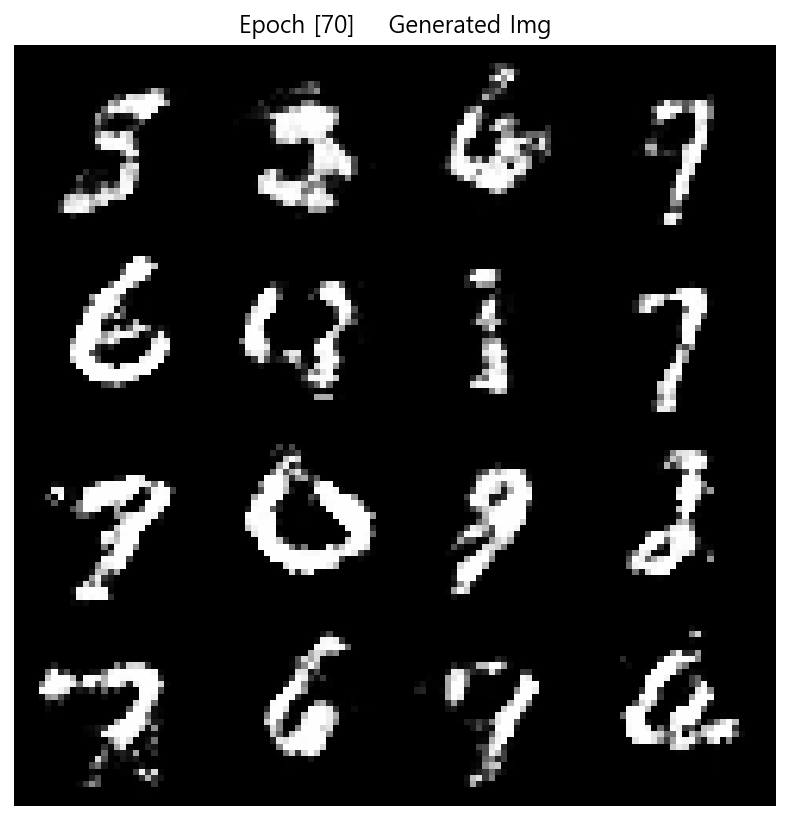

Epoch [71|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.116948 || -0.143620]    G_Loss 0.167166
Epoch [72|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.138891 || -0.171697]    G_Loss 0.180010
Epoch [73|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.152665 || -0.162757]    G_Loss 0.162140
Epoch [74|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.140662 || 0.124370]    G_Loss -0.120523
Epoch [75|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.069119 || 0.037865]    G_Loss -0.041928


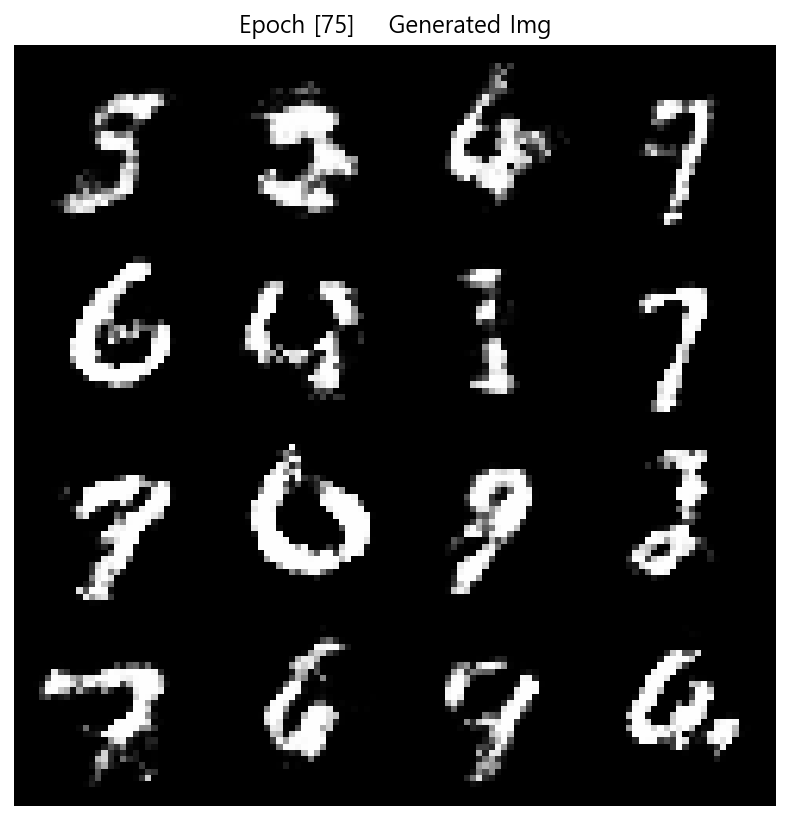

Epoch [76|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.239677 || -0.251268]    G_Loss 0.233878
Epoch [77|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.131875 || -0.159472]    G_Loss 0.182879
Epoch [78|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.337381 || 0.325807]    G_Loss -0.294870
Epoch [79|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.005862 || -0.036035]    G_Loss 0.046677
Epoch [80|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.234242 || 0.213255]    G_Loss -0.228841


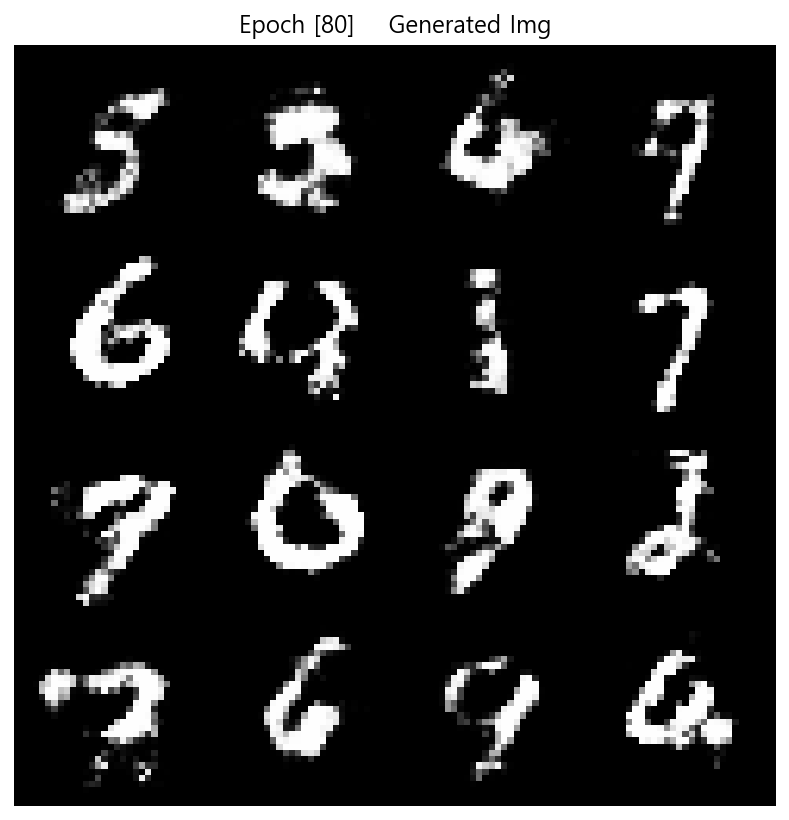

Epoch [81|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.130778 || 0.115739]    G_Loss -0.108663
Epoch [82|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.115025 || 0.103758]    G_Loss -0.063117
Epoch [83|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.126173 || -0.148003]    G_Loss 0.193141
Epoch [84|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.009647 || -0.053029]    G_Loss 0.035753
Epoch [85|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.258553 || 0.230662]    G_Loss -0.279316


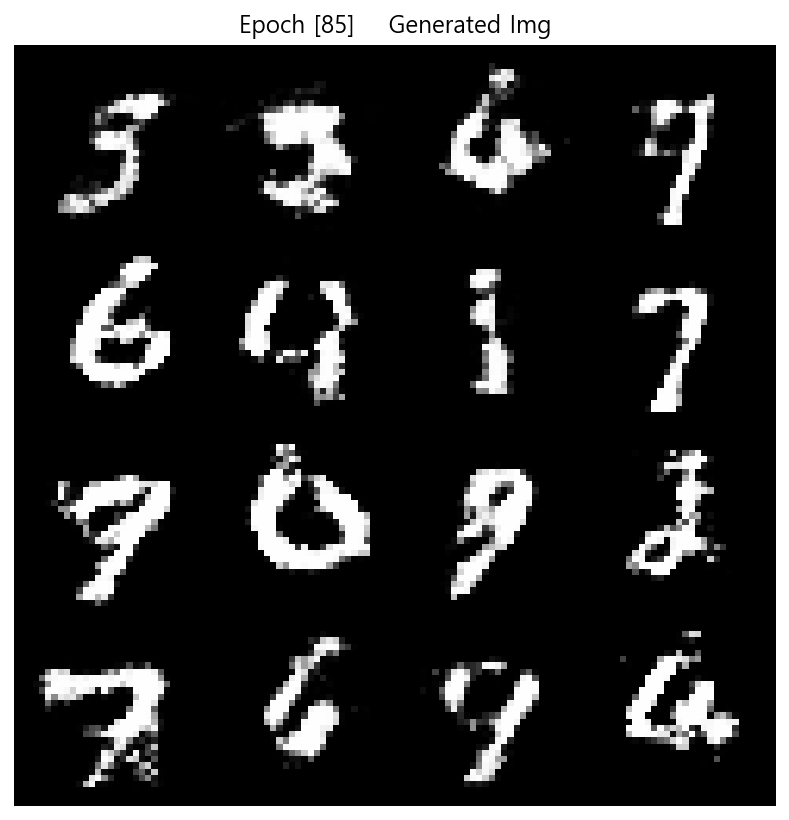

Epoch [86|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.214050 || -0.227146]    G_Loss 0.187474
Epoch [87|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.220777 || 0.204466]    G_Loss -0.193667
Epoch [88|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.788576 || 0.759635]    G_Loss -0.756794
Epoch [89|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.626979 || 0.610719]    G_Loss -0.635379
Epoch [90|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.032147 || -0.005248]    G_Loss 0.024026


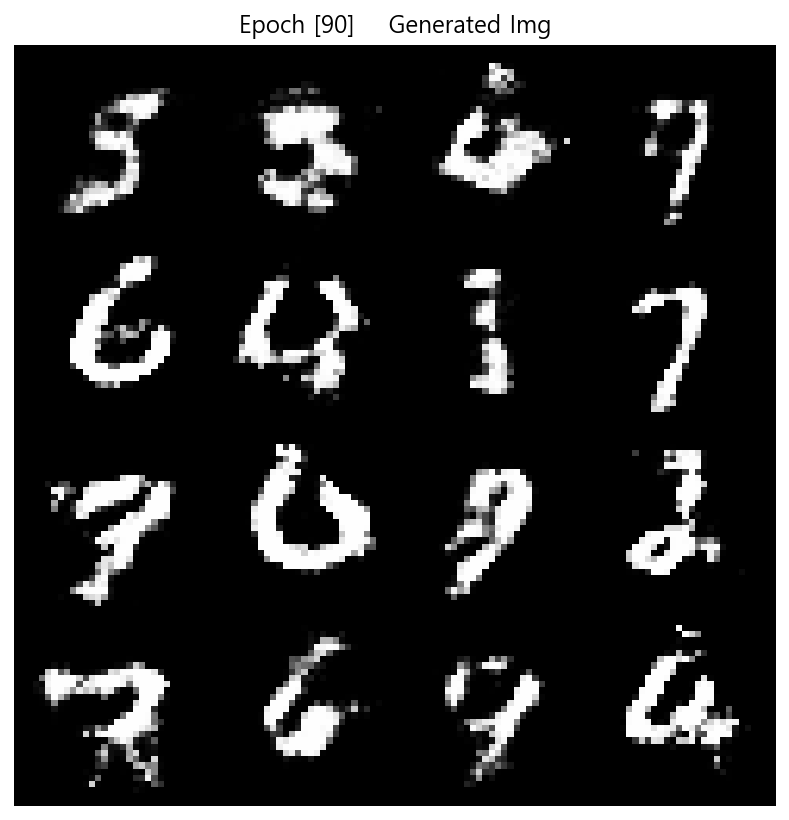

Epoch [91|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.749464 || -0.776014]    G_Loss 0.754481
Epoch [92|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.364399 || 0.323469]    G_Loss -0.355034
Epoch [93|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.338673 || -0.352214]    G_Loss 0.323806
Epoch [94|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.010177 || 1.021406]    G_Loss -0.981085
Epoch [95|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.151927 || -0.162255]    G_Loss 0.193078


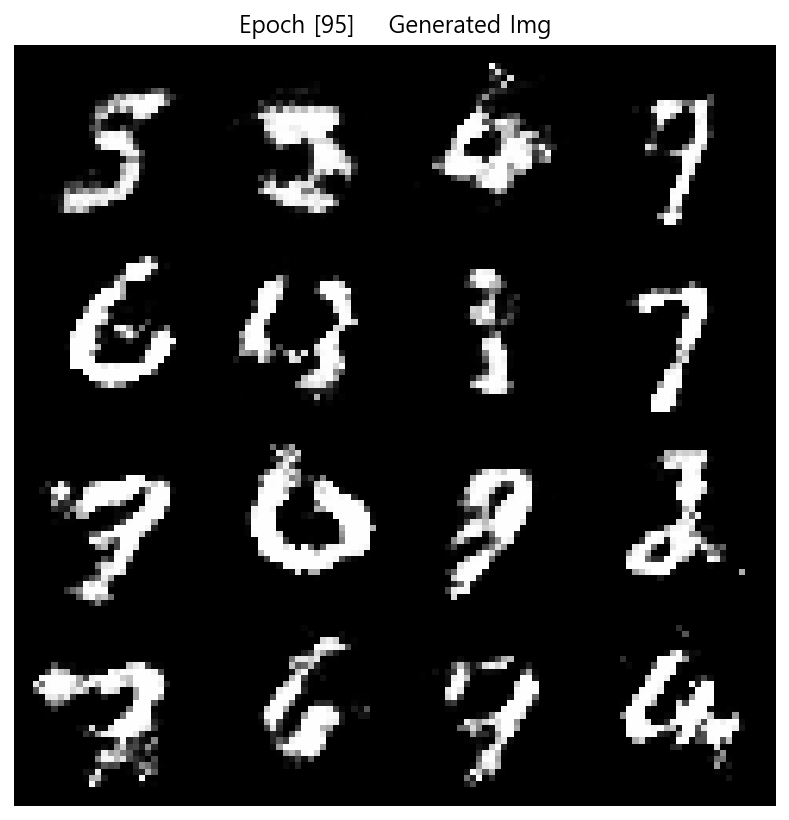

Epoch [96|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.511248 || -0.544097]    G_Loss 0.515182
Epoch [97|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.494416 || -0.519212]    G_Loss 0.528808
Epoch [98|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.439799 || -0.466139]    G_Loss 0.477209
Epoch [99|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.099876 || -0.108235]    G_Loss 0.097094
Epoch [100|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.177978 || -0.200487]    G_Loss 0.146748


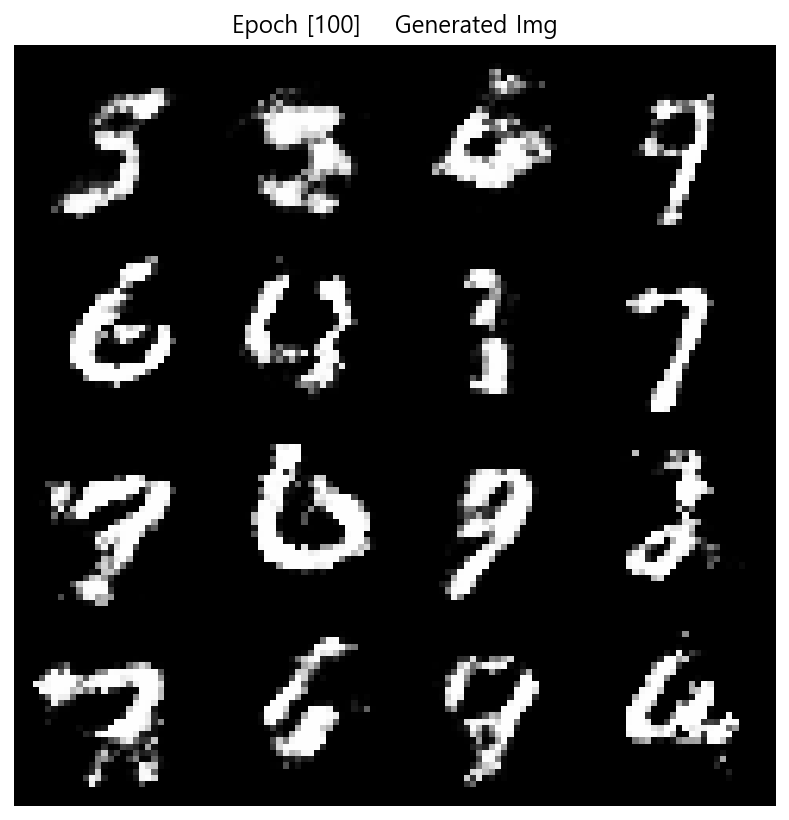

Epoch [101|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.531539 || -0.526472]    G_Loss 0.484710
Epoch [102|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.447143 || -0.466657]    G_Loss 0.515645
Epoch [103|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.134964 || 1.108965]    G_Loss -1.133154
Epoch [104|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.675636 || -0.672137]    G_Loss 0.688466
Epoch [105|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.166736 || -0.180342]    G_Loss 0.148879


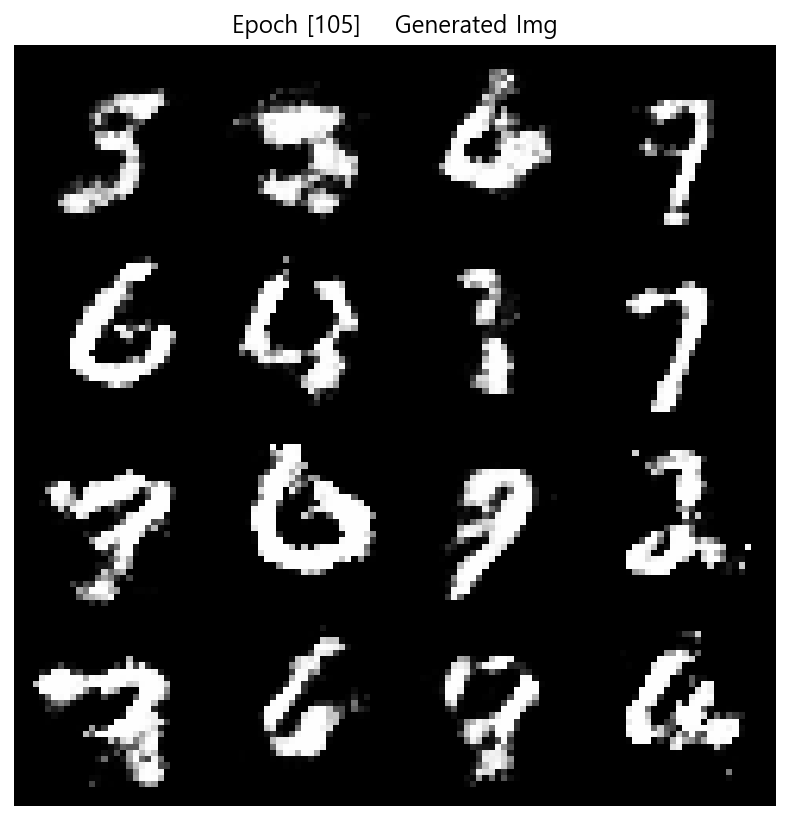

Epoch [106|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.700742 || -0.695412]    G_Loss 0.654405
Epoch [107|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.889927 || 0.872958]    G_Loss -0.861605
Epoch [108|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.539268 || 0.513528]    G_Loss -0.501575
Epoch [109|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.601821 || -0.660630]    G_Loss 0.614261
Epoch [110|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.016032 || -0.034159]    G_Loss 0.019267


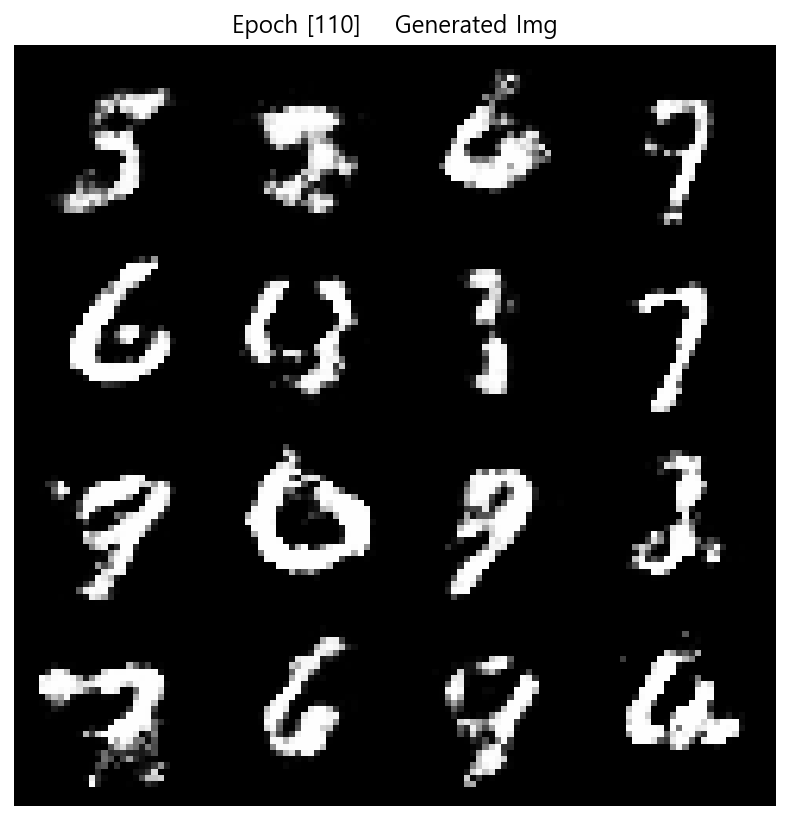

Epoch [111|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.359488 || 0.357509]    G_Loss -0.286409
Epoch [112|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.298609 || 0.273963]    G_Loss -0.292400
Epoch [113|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.083834 || -0.088616]    G_Loss 0.042484
Epoch [114|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.111426 || 0.084337]    G_Loss -0.032282
Epoch [115|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.070864 || -0.104283]    G_Loss 0.120684


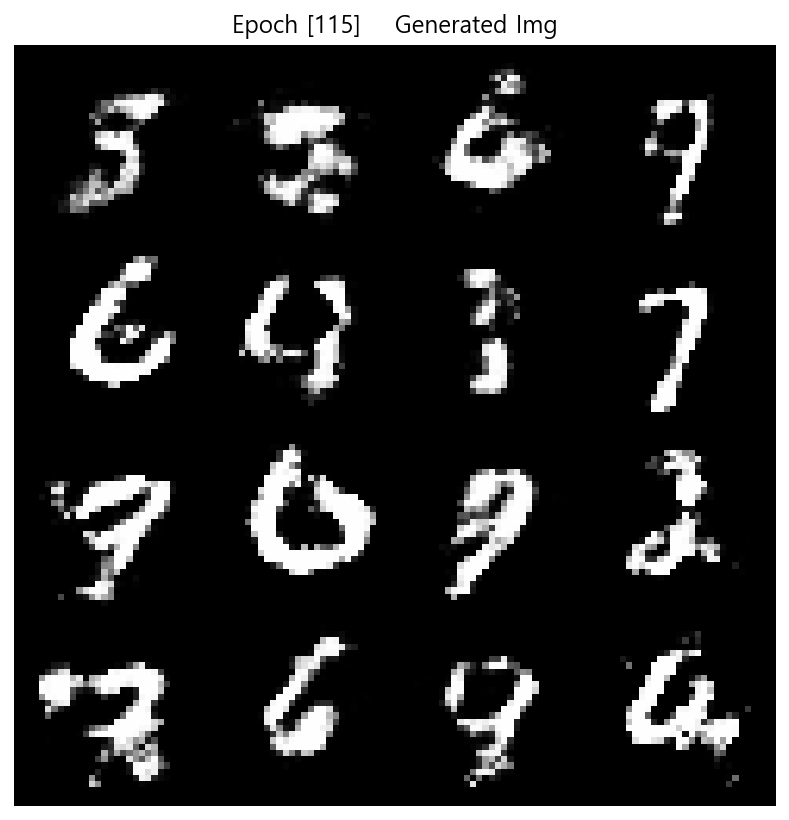

Epoch [116|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.868778 || -0.866697]    G_Loss 0.821862
Epoch [117|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [1.217030 || -1.259904]    G_Loss 1.032953
Epoch [118|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.254828 || -0.257943]    G_Loss 0.221584
Epoch [119|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.043236 || -0.047707]    G_Loss 0.000815
Epoch [120|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.756169 || -0.752707]    G_Loss 0.751132


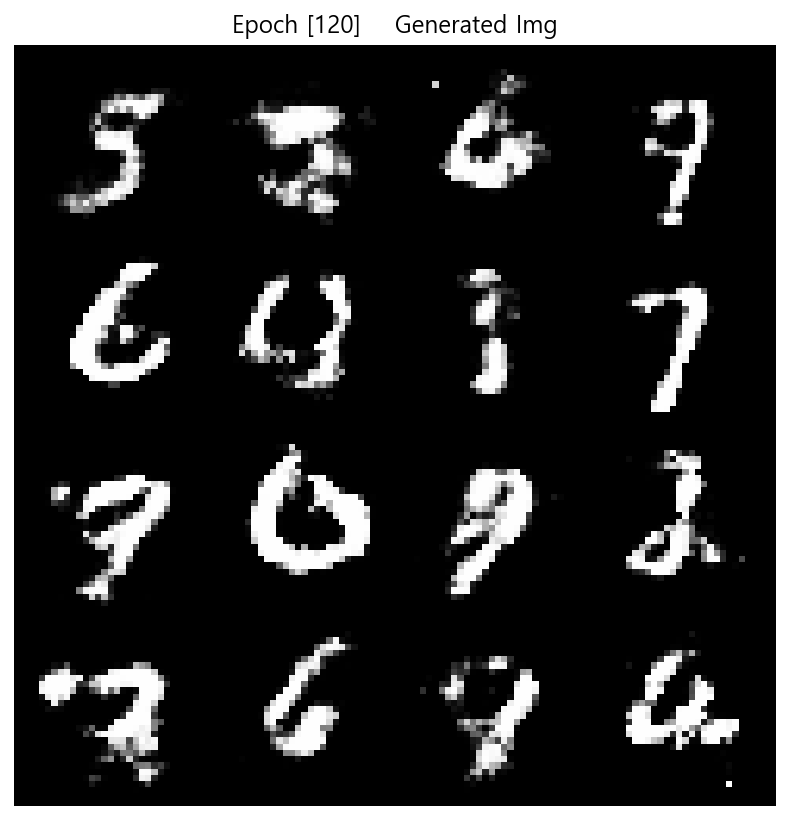

Epoch [121|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.102898 || 0.060320]    G_Loss -0.057689
Epoch [122|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.123644 || 0.098450]    G_Loss -0.125397
Epoch [123|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.322030 || -0.332430]    G_Loss 0.355224
Epoch [124|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.362000 || 0.321041]    G_Loss -0.390040
Epoch [125|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.181189 || 0.161866]    G_Loss -0.098124


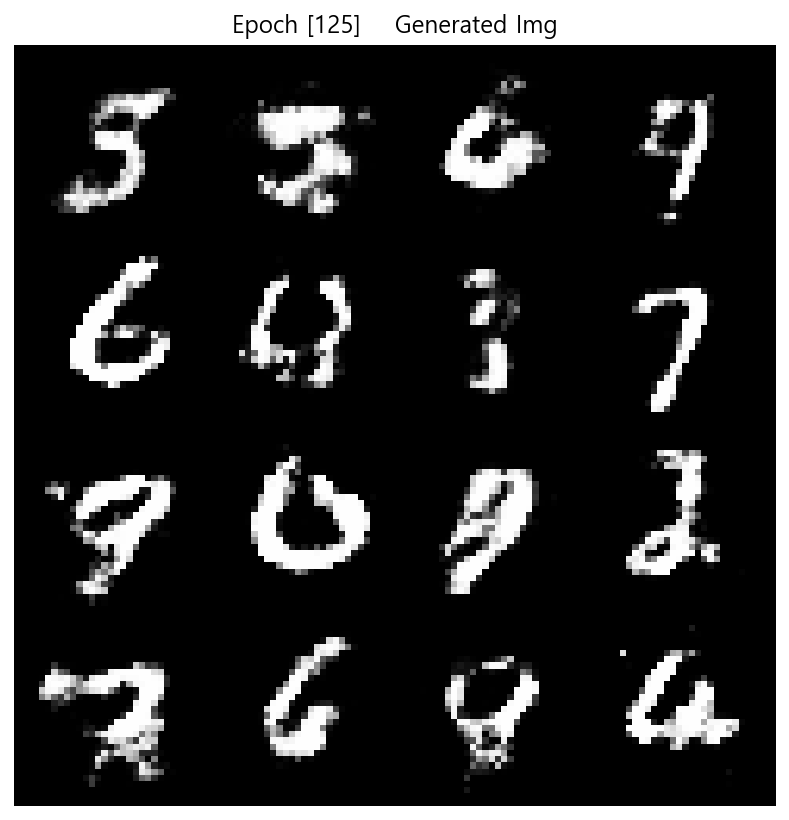

Epoch [126|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.566046 || 0.529116]    G_Loss -0.511066
Epoch [127|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.242105 || 0.234074]    G_Loss -0.330595
Epoch [128|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.458031 || 0.425115]    G_Loss -0.465867
Epoch [129|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.532032 || 0.492449]    G_Loss -0.428899
Epoch [130|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.278561 || -0.303821]    G_Loss 0.308520


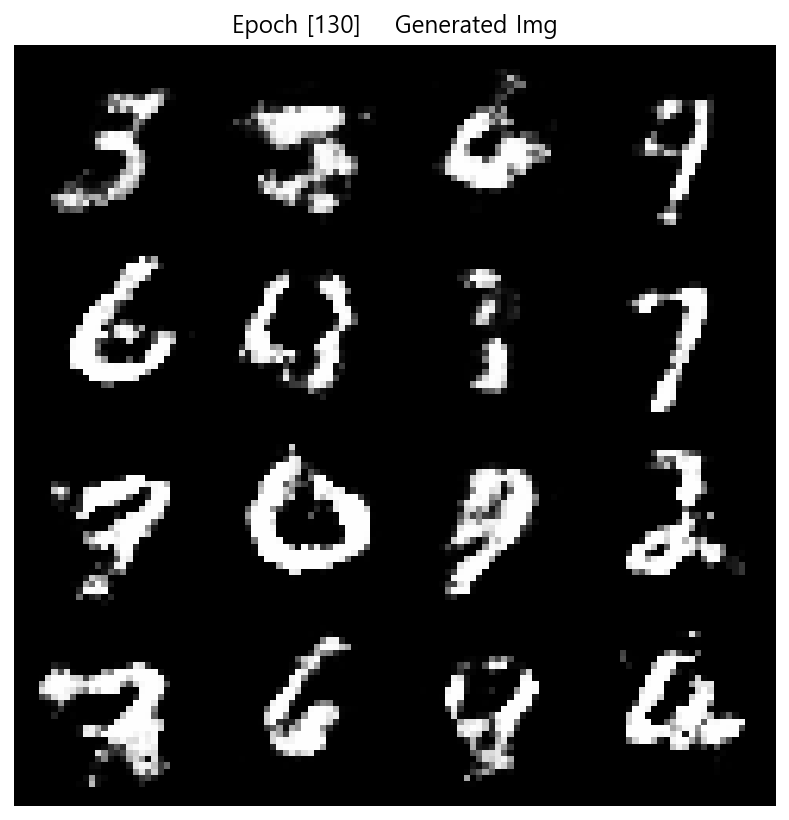

Epoch [131|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.199221 || 0.178824]    G_Loss -0.200327
Epoch [132|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.006547 || 1.012396]    G_Loss -1.016155
Epoch [133|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.423858 || 0.429202]    G_Loss -0.447670
Epoch [134|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.070902 || -0.116223]    G_Loss 0.128700
Epoch [135|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.271358 || 0.266563]    G_Loss -0.241997


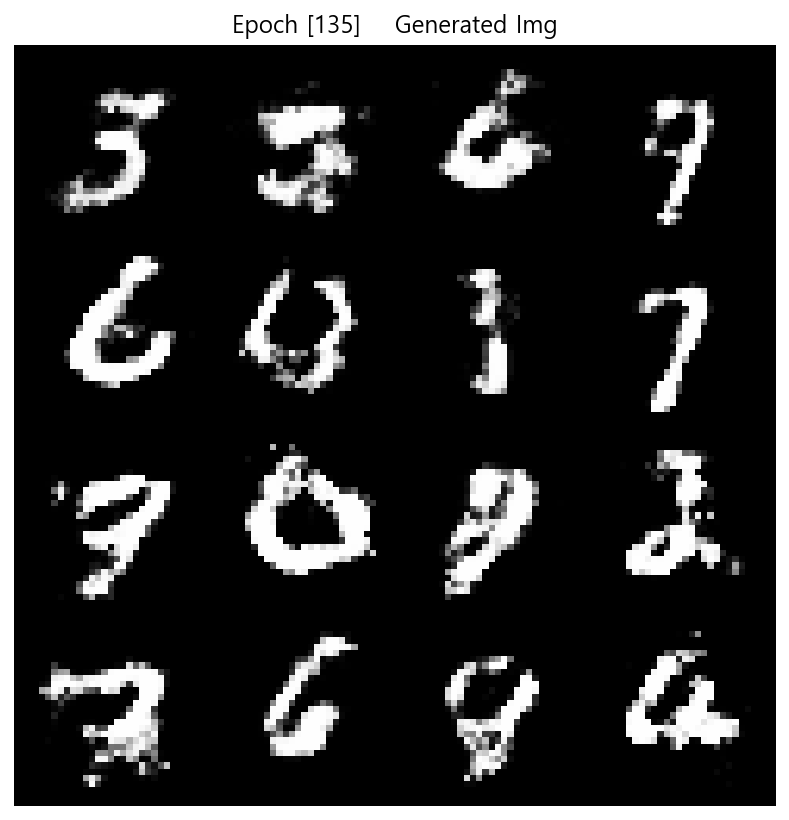

Epoch [136|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.302262 || 0.233067]    G_Loss -0.224342
Epoch [137|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.757850 || -0.826483]    G_Loss 0.876036
Epoch [138|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.925032 || 0.927306]    G_Loss -0.888431
Epoch [139|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.997392 || 0.928706]    G_Loss -0.974135
Epoch [140|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.132808 || 0.127724]    G_Loss -0.111844


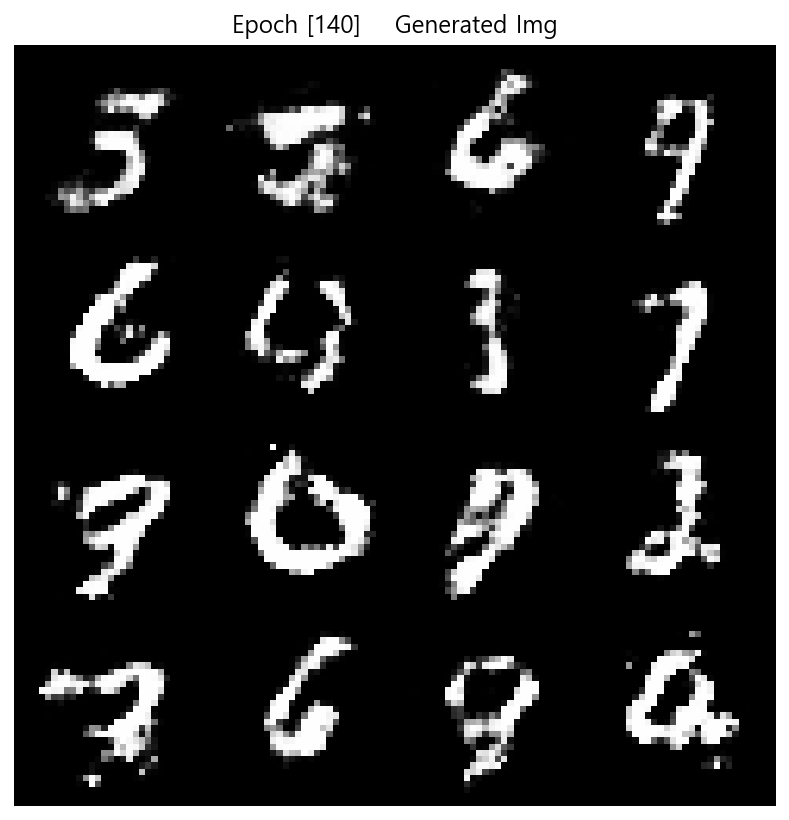

Epoch [141|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.110634 || 0.079964]    G_Loss -0.046834
Epoch [142|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.908596 || 0.888434]    G_Loss -0.824823
Epoch [143|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.069809 || 0.057779]    G_Loss -0.022208
Epoch [144|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.182294 || 0.143757]    G_Loss -0.102933
Epoch [145|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.007282 || -0.002590]    G_Loss -0.045624


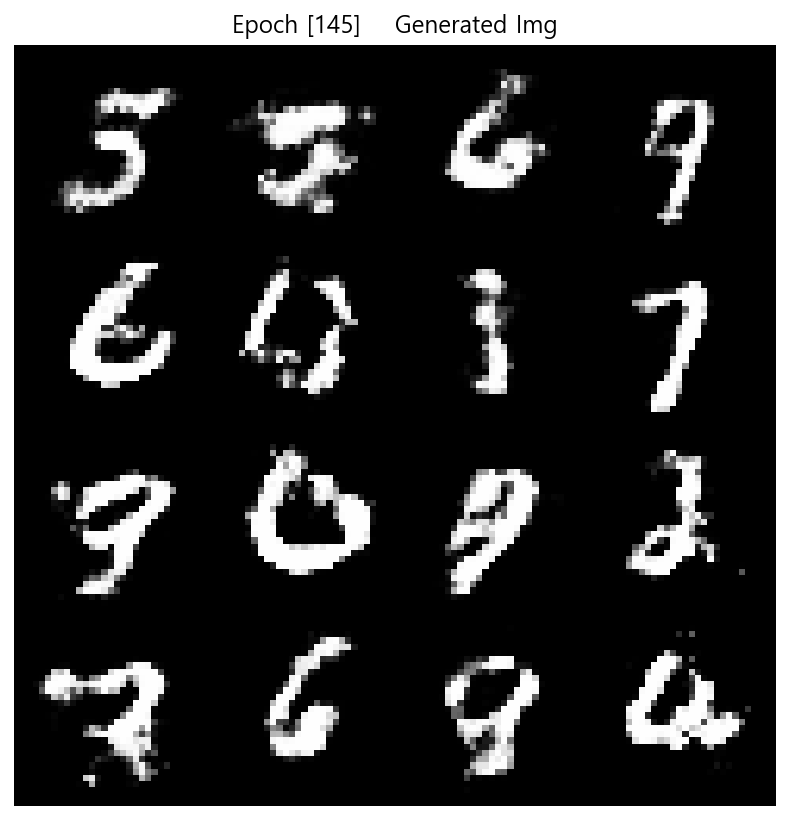

Epoch [146|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.160705 || 0.110585]    G_Loss -0.136177
Epoch [147|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.752074 || -0.744960]    G_Loss 0.721236
Epoch [148|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.284580 || 0.271578]    G_Loss -0.228571
Epoch [149|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.370540 || 0.346638]    G_Loss -0.332224
Epoch [150|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.189888 || -0.211016]    G_Loss 0.304251


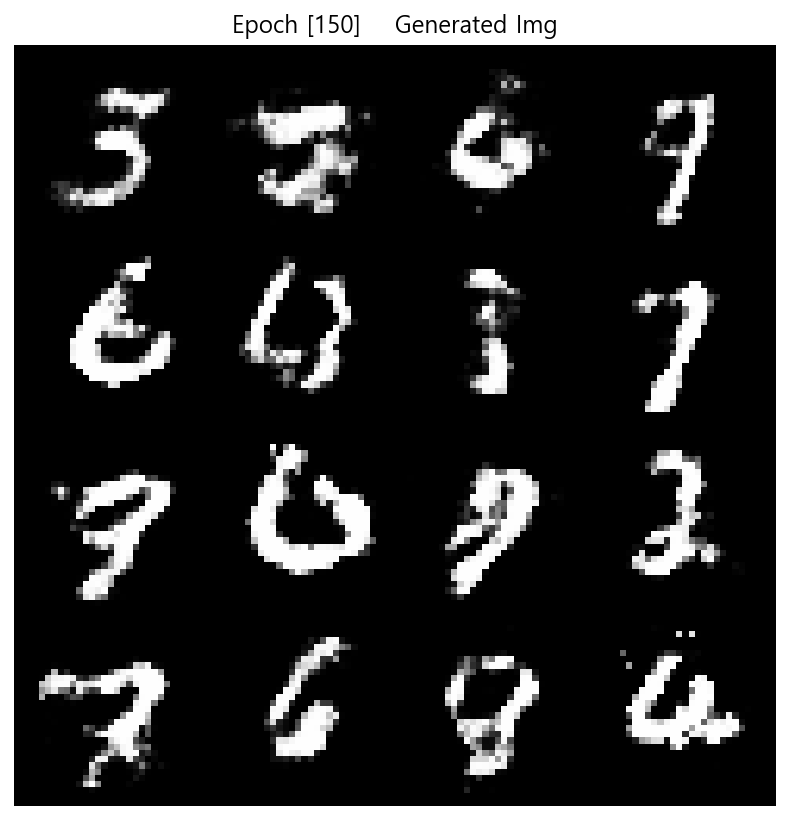

Epoch [151|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.860870 || -0.841122]    G_Loss 0.799762
Epoch [152|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.082227 || -0.105679]    G_Loss 0.124603
Epoch [153|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.463187 || -0.468213]    G_Loss 0.509970
Epoch [154|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.410882 || 0.388604]    G_Loss -0.456804
Epoch [155|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.824745 || -0.869449]    G_Loss 0.948056


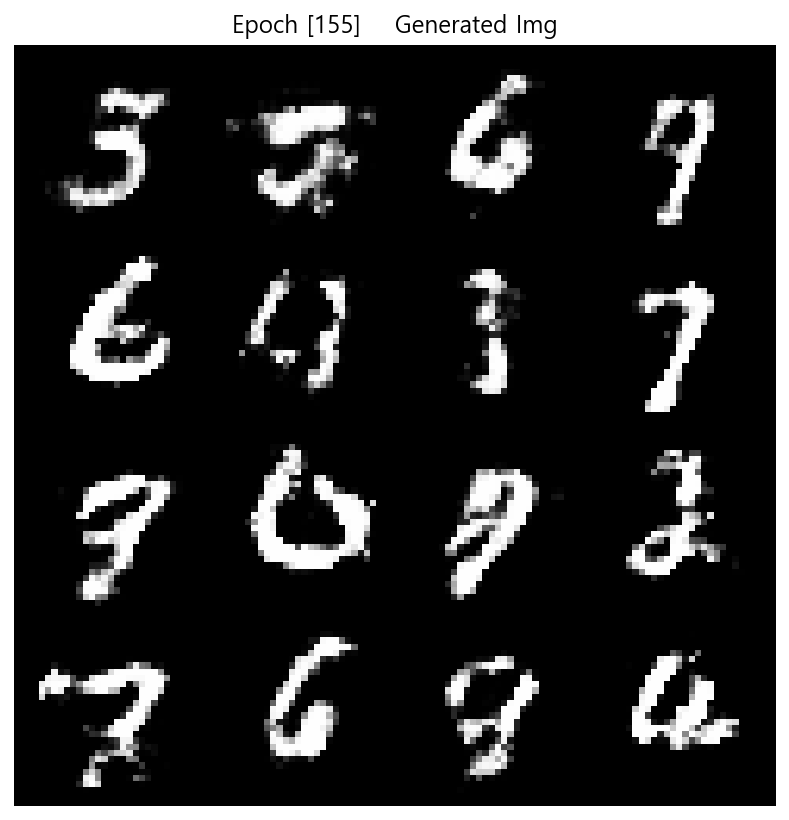

Epoch [156|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.107479 || -0.135006]    G_Loss 0.183094
Epoch [157|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.654565 || -0.680484]    G_Loss 0.662441
Epoch [158|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.108628 || -0.151272]    G_Loss 0.201871
Epoch [159|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.438823 || -0.476870]    G_Loss 0.563053
Epoch [160|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.087467 || -0.114815]    G_Loss 0.143506


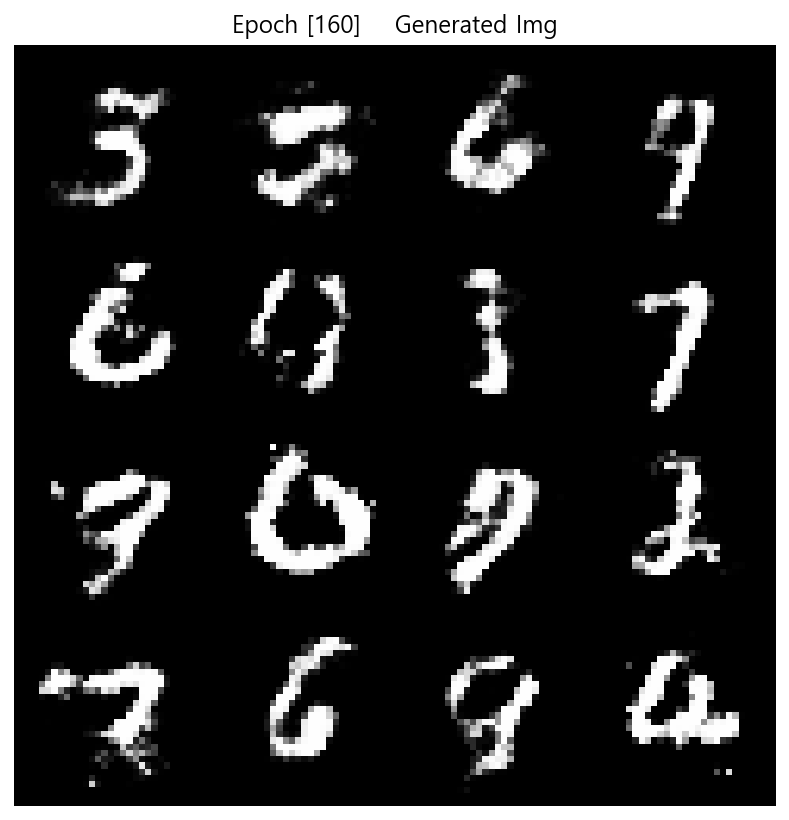

Epoch [161|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.142649 || -0.128921]    G_Loss 0.156946
Epoch [162|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.603417 || 0.588791]    G_Loss -0.519899
Epoch [163|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.442623 || -0.445381]    G_Loss 0.403920
Epoch [164|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.699849 || -0.719342]    G_Loss 0.702688
Epoch [165|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.293082 || -0.284205]    G_Loss 0.202444


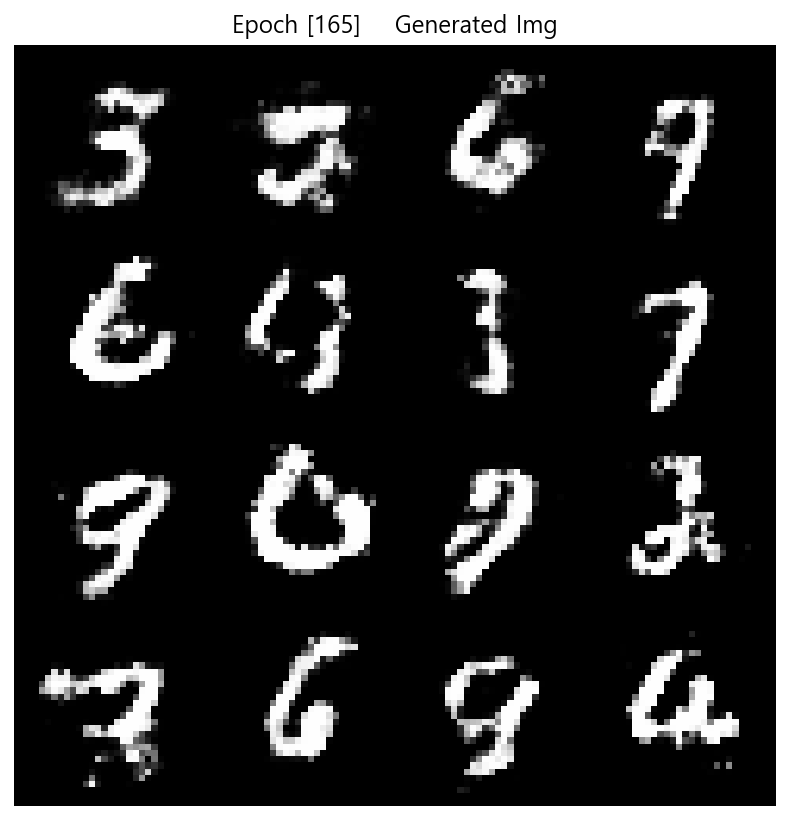

Epoch [166|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.027111 || 0.008436]    G_Loss 0.009193
Epoch [167|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [1.066472 || -1.056099]    G_Loss 1.015751
Epoch [168|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.223378 || 0.238663]    G_Loss -0.244096
Epoch [169|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.888327 || 0.854128]    G_Loss -0.908906
Epoch [170|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.214583 || -0.238456]    G_Loss 0.298719


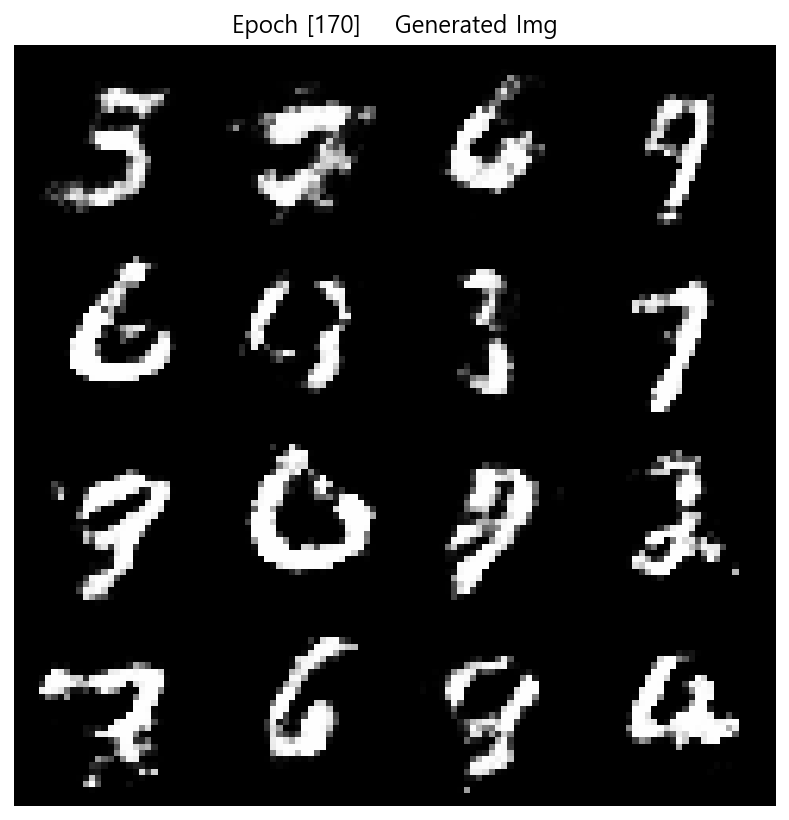

Epoch [171|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.098519 || -0.104640]    G_Loss 0.102693
Epoch [172|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.373343 || 0.343143]    G_Loss -0.342587
Epoch [173|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.262297 || -0.297221]    G_Loss 0.347056
Epoch [174|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.057588 || 0.043966]    G_Loss 0.001202
Epoch [175|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.669016 || -0.686797]    G_Loss 0.746771


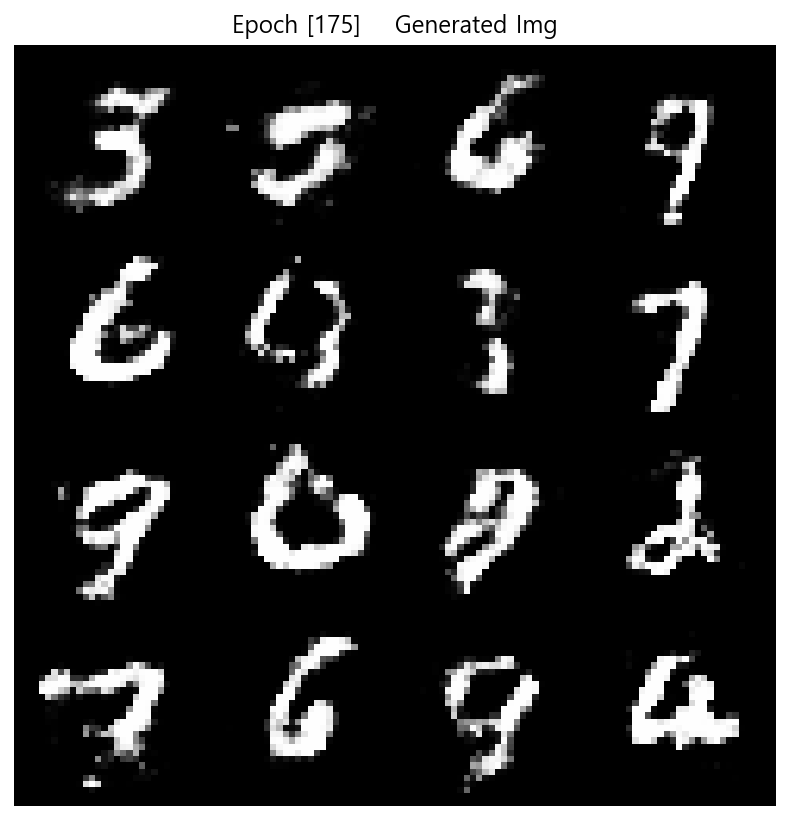

Epoch [176|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.111837 || -0.108015]    G_Loss 0.148792
Epoch [177|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.876678 || 0.868994]    G_Loss -0.849267
Epoch [178|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.045469 || -0.081602]    G_Loss -0.016547
Epoch [179|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.092806 || 0.055484]    G_Loss -0.074563
Epoch [180|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.132445 || 1.072271]    G_Loss -1.163569


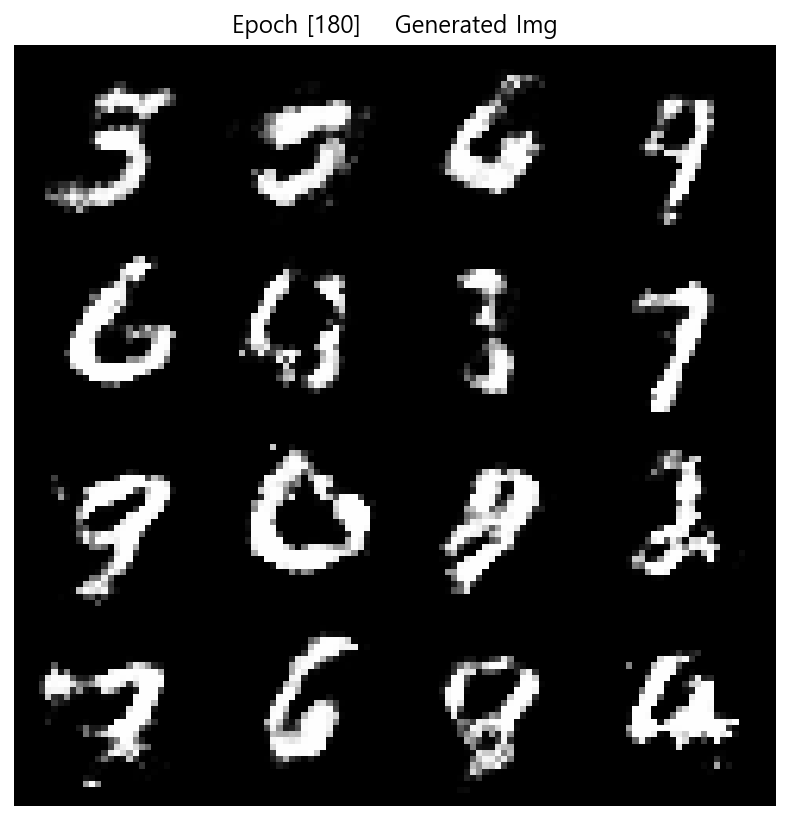

Epoch [181|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.002933 || -0.021635]    G_Loss 0.050064
Epoch [182|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.529519 || 0.529682]    G_Loss -0.442905
Epoch [183|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.079849 || -0.102298]    G_Loss 0.094330
Epoch [184|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.569355 || -0.605605]    G_Loss 0.679674
Epoch [185|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.112318 || 0.097054]    G_Loss -0.153976


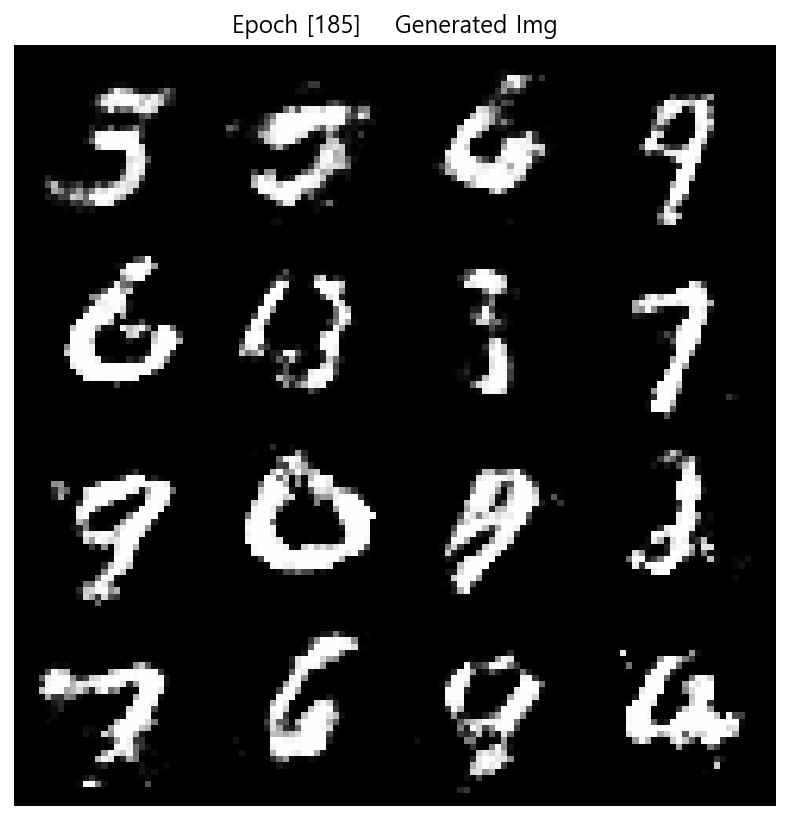

Epoch [186|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.423880 || -0.427296]    G_Loss 0.412415
Epoch [187|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.054564 || 1.043100]    G_Loss -1.001969
Epoch [188|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.995563 || 0.981655]    G_Loss -0.980153
Epoch [189|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.720189 || -0.747936]    G_Loss 0.729681
Epoch [190|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.842347 || -0.876178]    G_Loss 0.897797


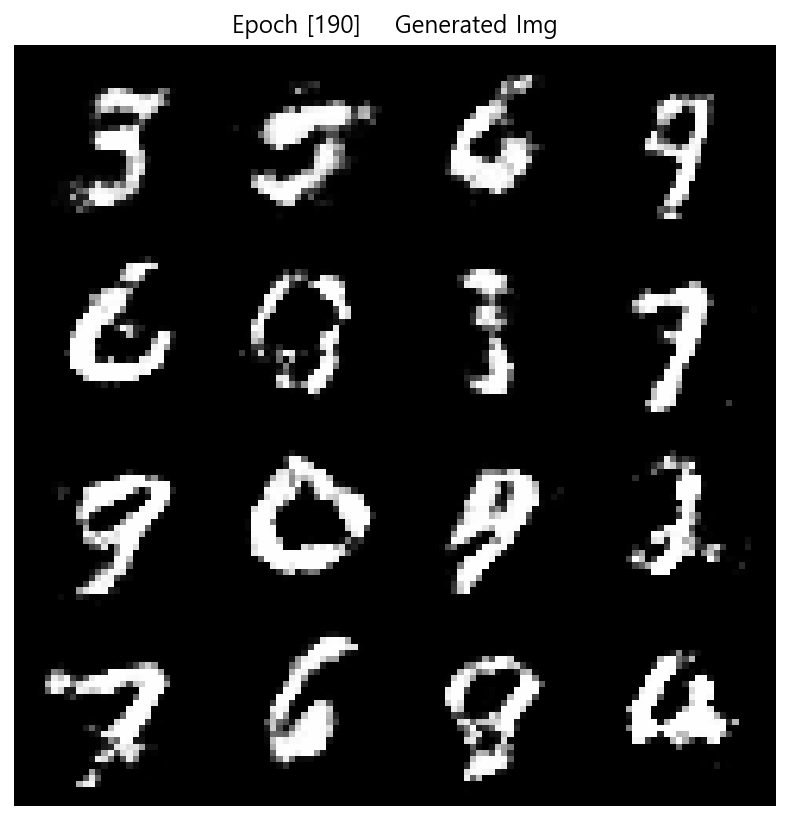

Epoch [191|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.943372 || 0.917388]    G_Loss -0.892995
Epoch [192|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-1.103986 || 1.088058]    G_Loss -1.110961
Epoch [193|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.101083 || -0.112980]    G_Loss -0.039473
Epoch [194|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.449016 || -0.437836]    G_Loss 0.495968
Epoch [195|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.742742 || 0.726582]    G_Loss -0.693900


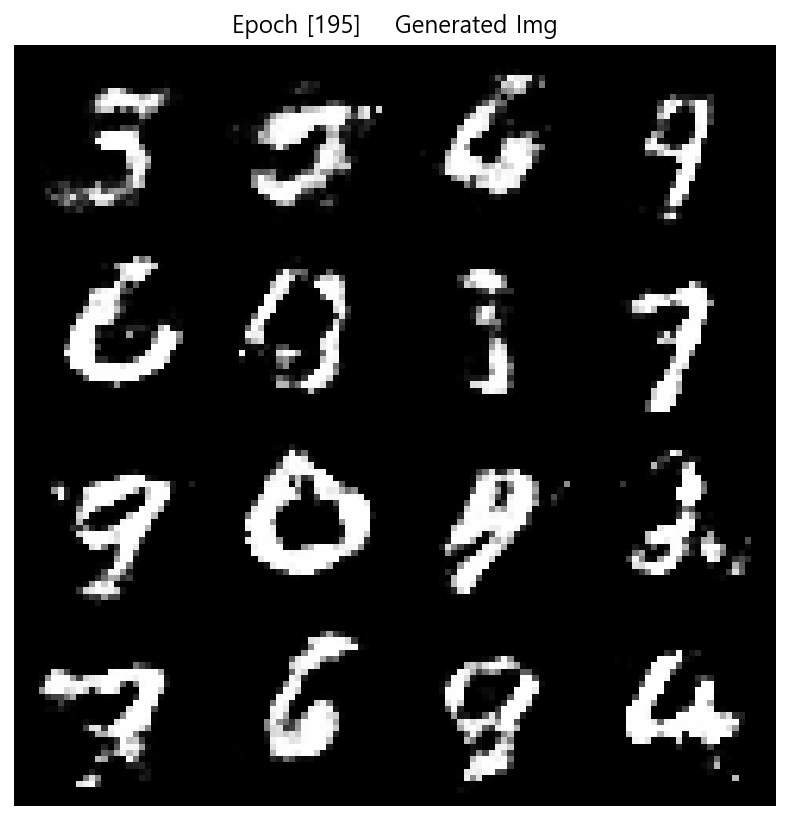

Epoch [196|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.738299 || 0.699248]    G_Loss -0.867782
Epoch [197|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.068171 || -0.044354]    G_Loss -0.024275
Epoch [198|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.749922 || 0.705458]    G_Loss -0.749730
Epoch [199|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [-0.043878 || -0.011879]    G_Loss -0.004630
Epoch [200|200]    Step [ 0.00%     0| 235]    D_Loss(Real||Fake) [0.533199 || -0.558282]    G_Loss 0.519015


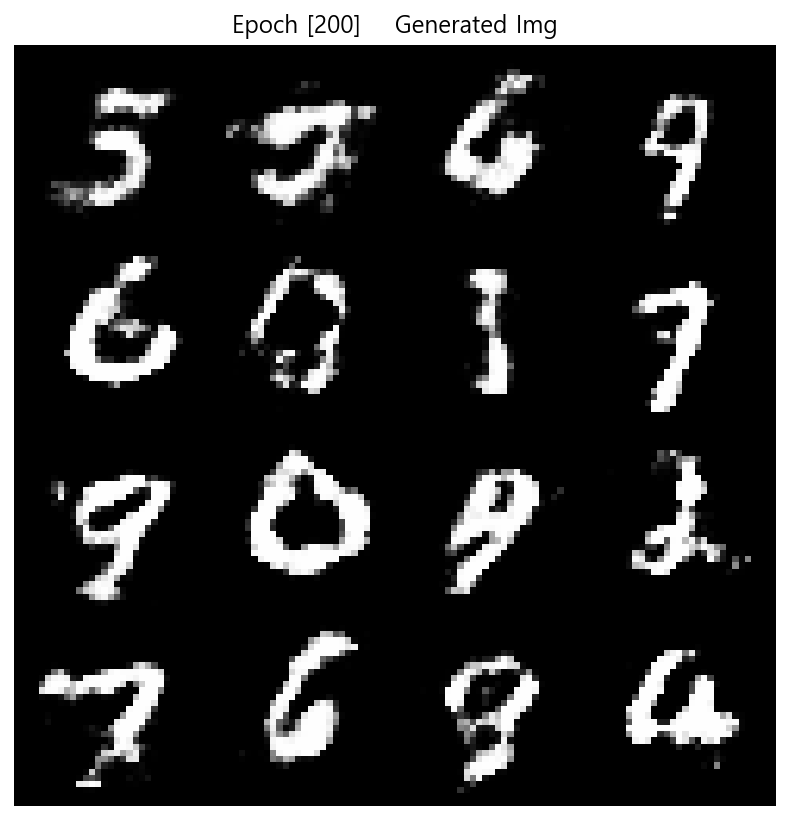

In [13]:
epochs = 200
test_batch_size = 16
random_fixed_latent = torch.randn((test_batch_size, latent_dim), dtype=torch.float).to(device)

for epoch in range(1, epochs+1):
    train(generator, discriminator, optimizer_G, optimizer_D, data_loader, epoch, epochs)
    if epoch % 5 == 0:
        test(generator, random_fixed_latent, epoch)